# Poleward Heat Transport

`mom6_tools.polar_heat_transport` collection of functions for computing and plotting poleward heat transport.

The goal of this notebook is the following:

1) server as an example on to compute polar heat transport using CESM/MOM6 output; 

2) evaluate model experiments by comparing transports against observed and other model estimates;

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
from mom6_tools.poleward_heat_transport import  *
from mom6_tools.m6toolbox import cime_xmlquery, add_global_attrs, genBasinMasks
from mom6_tools.m6toolbox import weighted_temporal_mean_vars
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from datetime import datetime, date
import yaml, os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr

Basemap module not found. Some regional plots may not function properly


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', casename)

Output directory is: /glade/derecho/scratch/gmarques/archive/g.e30_a07c_cesm.GJRAv4.TL319_t232_wgx3_hycom1_N75.2025.130/ocn/hist/
Casename is: g.e30_a07c_cesm.GJRAv4.TL319_t232_wgx3_hycom1_N75.2025.130


In [5]:
# create an empty class object
class args:
  pass

args.casename = casename
# set avg dates
avg = diag_config_yml['Avg']
args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.native = casename+diag_config_yml['Fnames']['native']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [6]:
if not os.path.isdir('ncfiles'):
    print('Creating a directory to store netcdf files (ncfiles)... \n')
    os.system('mkdir ncfiles')

Creating a directory to store netcdf files (ncfiles)... 



In [7]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)

try:
  depth = grd.depth_ocean.values
except:
  depth = grd.deptho.values

MOM6 grid successfully loaded... 



In [8]:
# basin masks - remove Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon.values, grd.geolat.values, depth, verbose=False)
basin_code_xr = genBasinMasks(grd.geolon.values, grd.geolat.values, depth, verbose=False, xda=True)

In [9]:
cluster = NCARCluster()
cluster.scale(args.nw)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:40495,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    
    variables = ['T_ady_2d', 'T_diffy_2d', 'T_hbd_diffy_2d']
    for var in variables:
      print('Processing {}'.format(var))
      if var not in ds.variables:
        print('WARNING: ds does not have variable {}. Creating dataarray with zeros'.format(var))
        jm, im = grd.geolat.shape
        tm = len(ds.time)
        da = xr.DataArray(np.zeros((tm, jm, im)), dims=['time', 'yq','xh'], \
             coords={'yq' : grd.yq, 'xh' : grd.xh, 'time' : ds.time}).rename(var)
        ds = xr.merge([ds, da])
    return ds[variables]

In [11]:
print('\n Reading monthly native history files...')
# load data

%time ds = xr.open_mfdataset(OUTDIR+'/'+args.native, \
         parallel=True, data_vars='minimal', chunks={'time': 12},\
         coords='minimal', compat='override', preprocess=preprocess)


 Reading monthly native history files...
CPU times: user 1.55 s, sys: 589 ms, total: 2.14 s
Wall time: 22.3 s


In [12]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date)).load()


 Selecting data between 0006-01-01 and 0021-01-01...
CPU times: user 1.27 s, sys: 441 ms, total: 1.71 s
Wall time: 6.52 s


In [13]:
attrs =  {
         'description': 'Annual mean of poleward heat transport by components ', 
         'start_date': args.start_date, 
         'end_date': args.end_date, 
         'reduction_method': 'annual mean weighted by days in each month',
         'casename': casename
         }

In [14]:
ds_ann =  weighted_temporal_mean_vars(ds_sel,attrs=attrs)

In [33]:
# Heat Transport Time Series at 26.5°N (Atlantic)
ds_atl_ts =  (ds*basin_code_xr.sel(region='AtlanticOcean').rename({'yh':'yq'})).sel(yq=26.5, 
                                    method='nearest').sum('xh').drop('yq')
#ds_atl_ts

In [43]:
# Heat Transport Time Series at the Equator (Global)
ds_eq_ts =  ds.sel(yq=0.0, method='nearest').sum('xh').drop('yq')
# Build a rename mapping
rename_dict = {var: f"{var}_26.5" for var in ds_eq_ts.data_vars}
# Apply renaming
ds_eq_ts = ds_eq_ts.rename(rename_dict)
ds_eq_ts

<xarray.Dataset> Size: 5kB
Dimensions:              (time: 240)
Coordinates:
  * time                 (time) object 2kB 0001-01-16 12:00:00 ... 0020-12-16...
Data variables:
    T_ady_2d_26.5        (time) float32 960B dask.array<chunksize=(1,), meta=np.ndarray>
    T_diffy_2d_26.5      (time) float32 960B dask.array<chunksize=(1,), meta=np.ndarray>
    T_hbd_diffy_2d_26.5  (time) float32 960B dask.array<chunksize=(1,), meta=np.ndarray>

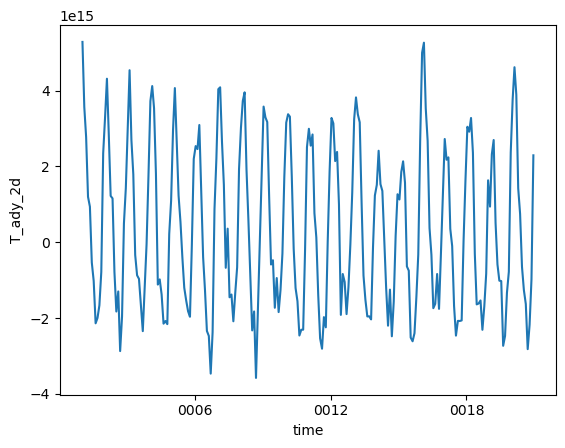

In [35]:
%matplotlib inline
ds_eq_ts.T_ady_2d[:].plot()
plt.show()

In [39]:
ds_mean = ds_ann.mean('time').load()
ds_mean

<xarray.Dataset> Size: 6MB
Dimensions:         (xh: 540, yq: 480)
Coordinates:
  * xh              (xh) float64 4kB -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * yq              (yq) float64 4kB -81.51 -81.41 -81.31 ... 87.68 87.73 87.74
Data variables:
    T_ady_2d        (yq, xh) float64 2MB nan nan nan nan nan ... nan nan nan nan
    T_diffy_2d      (yq, xh) float64 2MB nan nan nan nan nan ... nan nan nan nan
    T_hbd_diffy_2d  (yq, xh) float64 2MB nan nan nan nan nan ... nan nan nan nan

In [15]:
varName = 'T_ady_2d'
print('Saving netCDF files...')

if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')
        
ds_mean = ds_ann.mean('time').load()
attrs = {'description': 'Time-mean poleward heat transport by components ', 'units': ds[varName].units,
       'start_date': args.start_date, 'end_date': args.end_date, 'casename': casename}
add_global_attrs(ds_mean,attrs)
ds_mean.to_netcdf('ncfiles/'+casename+'_heat_transport.nc')

Saving netCDF files...


In [16]:
# fix coords
basin_code_xr['xh'] = ds_sel.xh
basin_code_xr = basin_code_xr.rename({'yh':'yq'})
basin_code_xr['yq'] = ds_sel.yq
basin_code_xr.to_netcdf('ncfiles/'+casename+'_region_masks.nc')

## Hovmoller plots

### Global

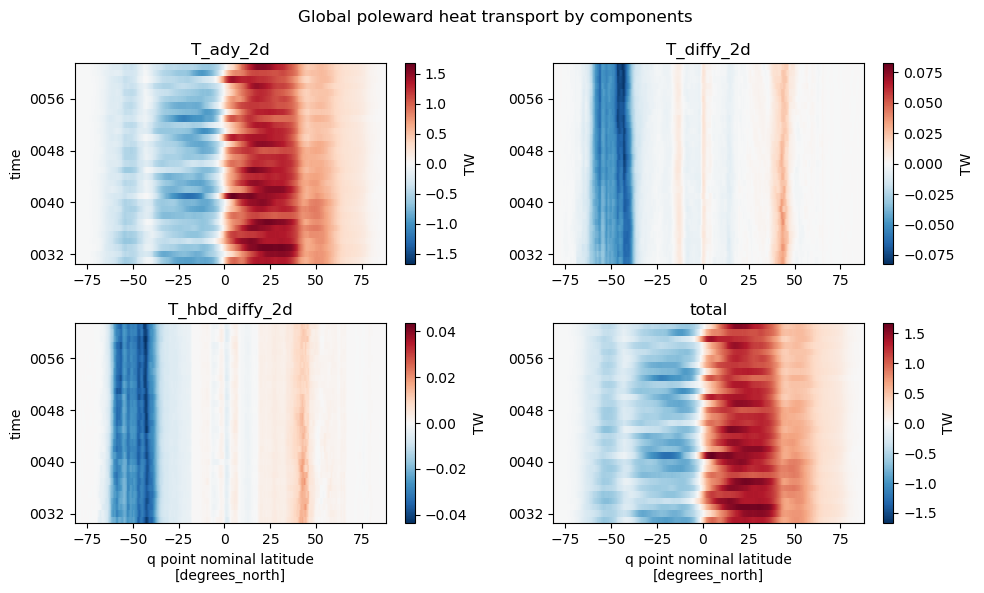

In [17]:
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
plt.suptitle('Global poleward heat transport by components')

#T_ady_2d
(ds_ann.T_ady_2d*1.0e-15).sum(dim='xh').plot(ax=ax1,cbar_kwargs={"label": "TW"});
ax1.set_title("T_ady_2d")
ax1.set_xlabel("")

# T_diffy_2d
(ds_ann.T_diffy_2d*1.0e-15).sum(dim='xh').plot(ax=ax2,cbar_kwargs={"label": "TW"});
ax2.set_title("T_diffy_2d")
ax2.set_xlabel("")
ax2.set_ylabel("")

# T_hbd_diffy_2d
(ds_ann.T_hbd_diffy_2d*1.0e-15).sum(dim='xh').plot(ax=ax3,cbar_kwargs={"label": "TW"});
ax3.set_title("T_hbd_diffy_2d")

# T_hbd_diffy_2d
total = (ds_ann.T_hbd_diffy_2d + ds_ann.T_diffy_2d + ds_ann.T_ady_2d).rename('total')
(total*1.0e-15).sum(dim='xh').plot(ax=ax4,cbar_kwargs={"label": "TW"});
ax4.set_title("total")
ax4.set_ylabel("")

# Make it nice
plt.tight_layout()

### Atlantic

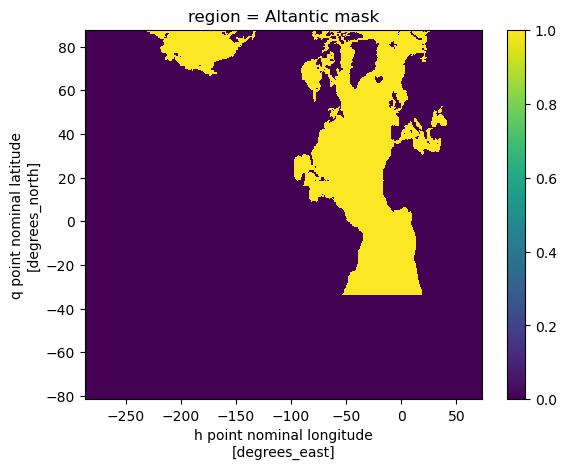

In [18]:
atl = (basin_code_xr.sel(region='MedSea') + basin_code_xr.sel(region='HudsonBay') +     \
      basin_code_xr.sel(region='Arctic') + basin_code_xr.sel(region='AtlanticOcean') + \
      basin_code_xr.sel(region='BlackSea'))
atl['region'] = 'Altantic mask'
atl.plot();

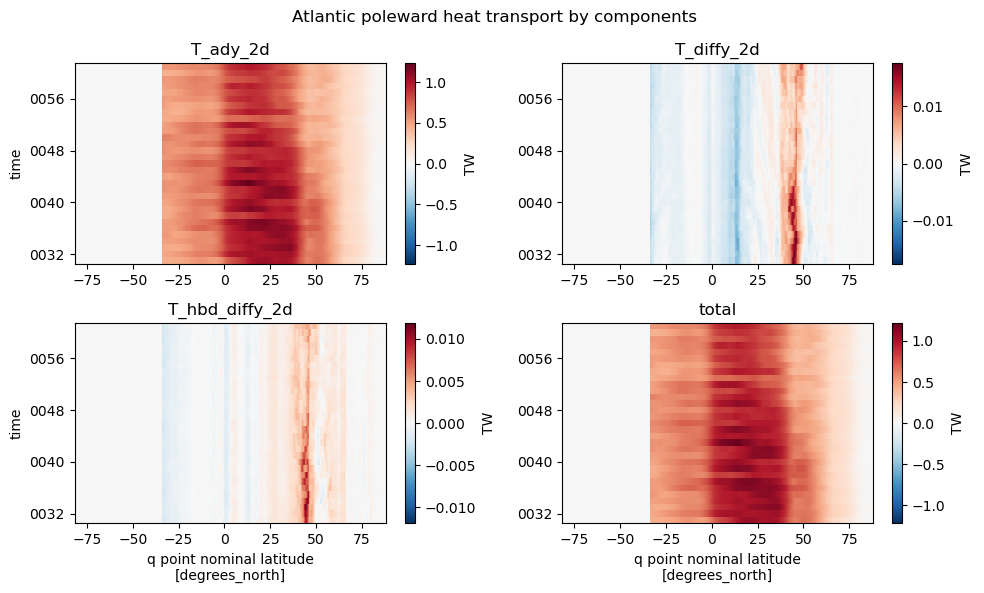

In [19]:
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
plt.suptitle('Atlantic poleward heat transport by components')

#T_ady_2d
(ds_ann.T_ady_2d*1.0e-15*atl).sum(dim='xh').plot(ax=ax1,cbar_kwargs={"label": "TW"});
ax1.set_title("T_ady_2d")
ax1.set_xlabel("")

# T_diffy_2d
(ds_ann.T_diffy_2d*1.0e-15*atl).sum(dim='xh').plot(ax=ax2,cbar_kwargs={"label": "TW"});
ax2.set_title("T_diffy_2d")
ax2.set_xlabel("")
ax2.set_ylabel("")

# T_hbd_diffy_2d
(ds_ann.T_hbd_diffy_2d*1.0e-15*atl).sum(dim='xh').plot(ax=ax3,cbar_kwargs={"label": "TW"});
ax3.set_title("T_hbd_diffy_2d")

# T_hbd_diffy_2d
total = (ds_ann.T_hbd_diffy_2d + ds_ann.T_diffy_2d + ds_ann.T_ady_2d).rename('total')
(total*1.0e-15*atl).sum(dim='xh').plot(ax=ax4,cbar_kwargs={"label": "TW"});
ax4.set_title("total")
ax4.set_ylabel("")

# Make it nice
plt.tight_layout()

## Compute temporal mean for each term

In [20]:
stream = True
# create a ndarray subclass
class C(np.ndarray): pass

In [21]:
# advection
varName = 'T_ady_2d'
if varName in ds_sel.variables:
  tmp = np.ma.masked_invalid(ds_ann[varName].mean('time').values)
  tmp = tmp[:].filled(0.)
  advective = tmp.view(C)
  advective.units = ds_ann[varName].units
else:
  raise Exception('Could not find "T_ady_2d" in ds')

In [22]:
# neutral diffusion
varName = 'T_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_ann[varName].mean('time').values)
  tmp = tmp[:].filled(0.)
  diffusive = tmp.view(C)
  diffusive.units = ds_ann[varName].units
else:
  diffusive = None
  warnings.warn('Neutrally-diffusive temperature term not found. This will result in an underestimation of the heat transport.')

In [23]:
# horizontal diffusion
varName = 'T_hbd_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_ann[varName].mean('time').values)
  tmp = tmp[:].filled(0.)
  hbd = tmp.view(C)
  hbd.units = ds_ann[varName].units
else:
  hbd = None
  warnings.warn('Horizontal diffusion term not found. This will result in an underestimation of the heat transport.')

In [24]:
# release workers
client.close(); cluster.close()

## Plotting

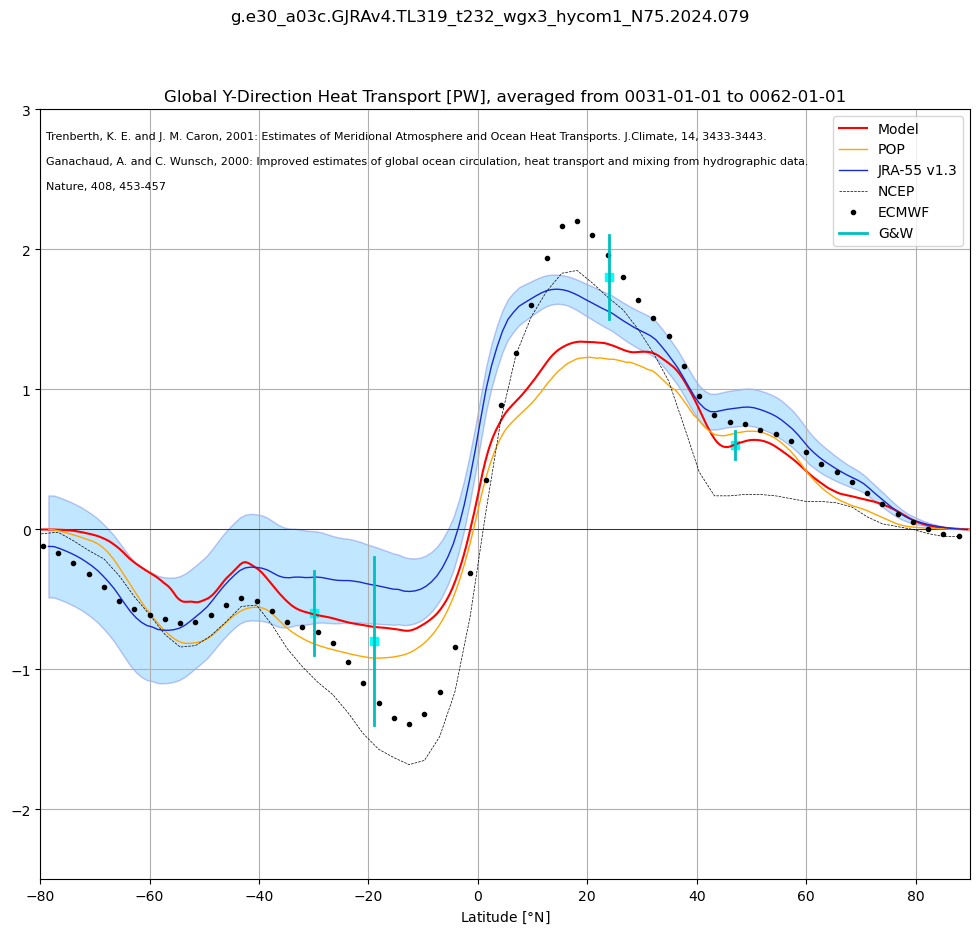

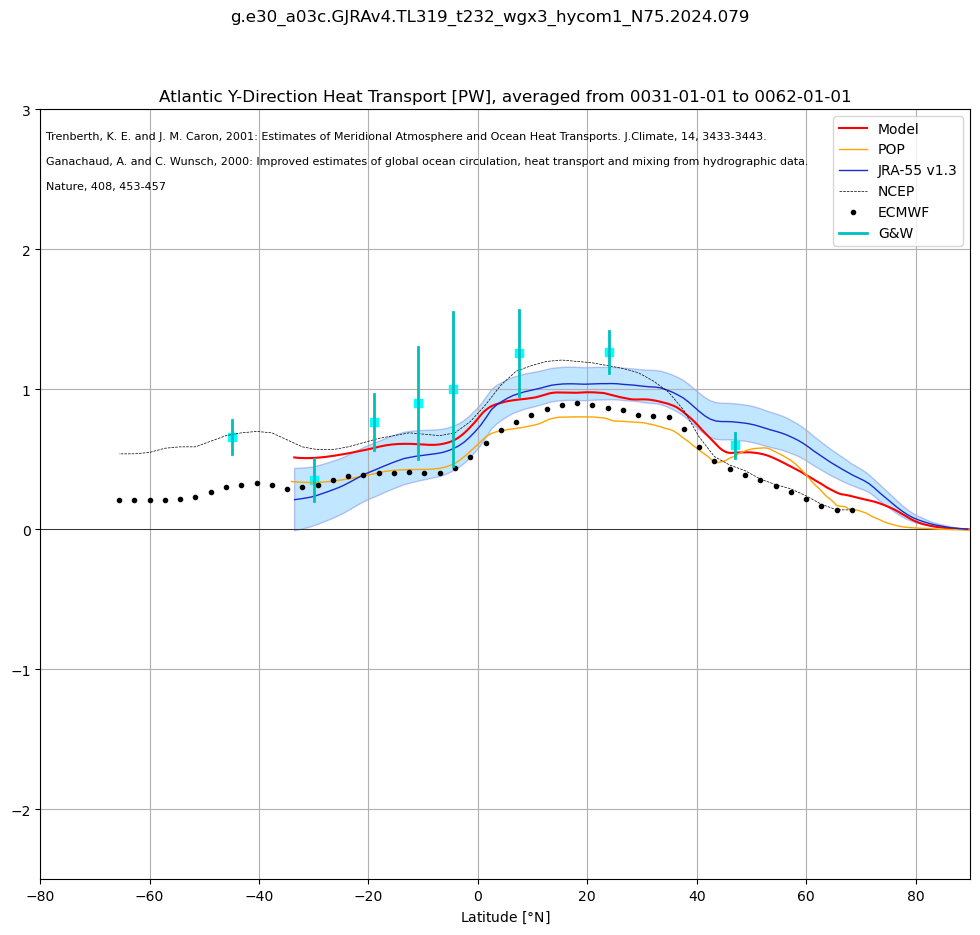

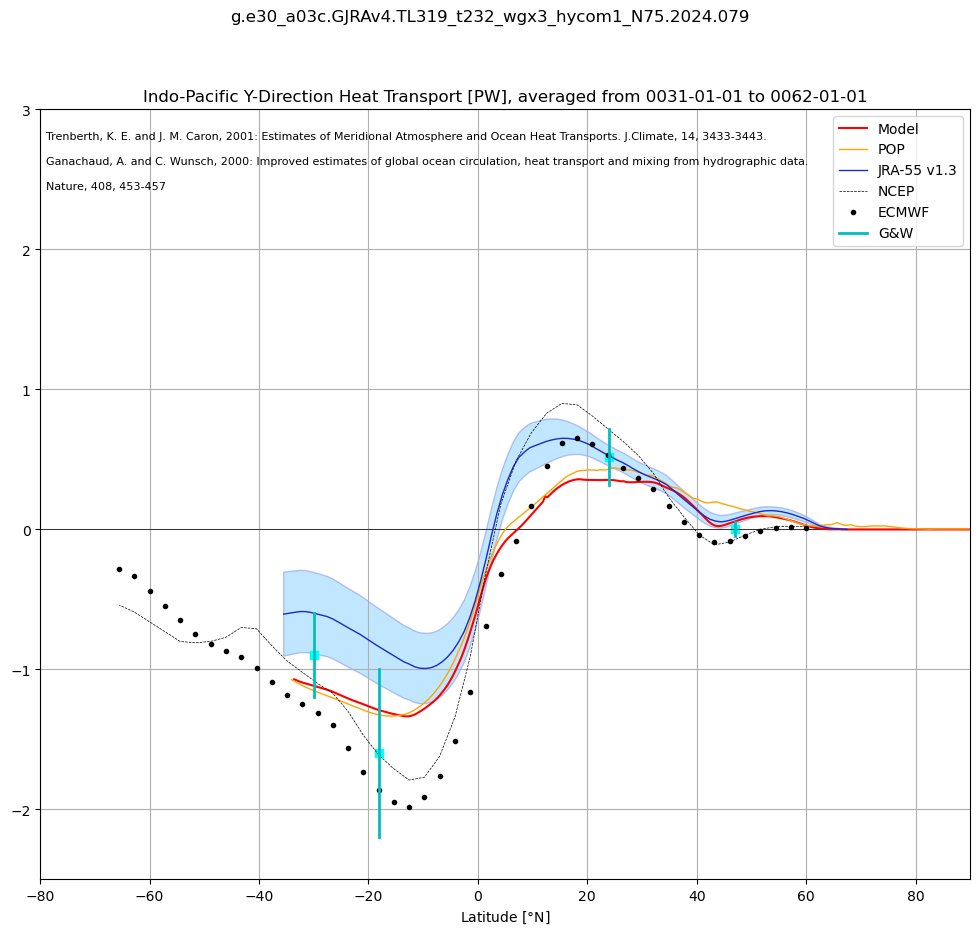

poleward_heat_transport.py was run successfully!


In [25]:
%matplotlib inline
plt_heat_transport_model_vs_obs(advective, diffusive, hbd, basin_code, grd, args)  